# 🧴 Bodywash NLP Case Study - Maven Magnet

In [34]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import re, string, itertools, requests, json, time, os
from collections import Counter
from tqdm import tqdm;

# 🔐 Load environment variables safely
import os
from dotenv import load_dotenv

# Load from .env file (located in project root)
load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")

if not GROQ_API_KEY:
    raise ValueError("❌ GROQ_API_KEY not found! Make sure your .env file exists and contains the key.")

print("✅ API key loaded securely from .env file.")


✅ API key loaded securely from .env file.


# 1️⃣ Load and Inspect Data

In [22]:
train_df = pd.read_excel("../datasets/bodywash-train.xlsx")
test_df  = pd.read_excel("../datasets/bodywash-test.xlsx")
train_df.columns = [c.strip() for c in train_df.columns]
test_df.columns  = [c.strip() for c in test_df.columns]
print(f"✅ Train shape: {train_df.shape}")
print(f"✅ Test shape : {test_df.shape}")



✅ Train shape: (7744, 2)
✅ Test shape : (127, 2)


# 2️⃣ Basic Info & Descriptive Stats

       text_len_words
count     7744.000000
mean        37.294421
std         33.217606
min          1.000000
25%         14.000000
50%         30.000000
75%         52.000000
max        481.000000


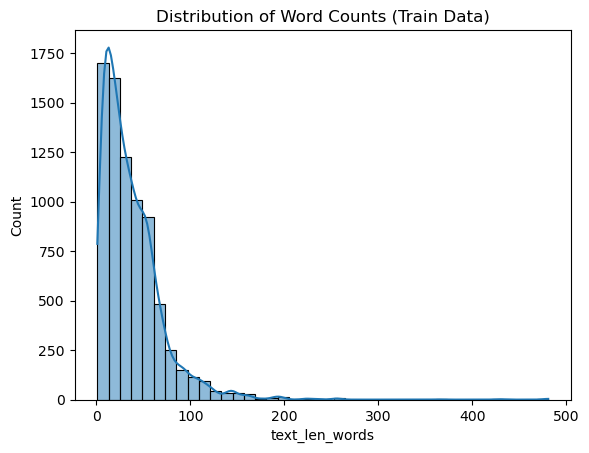

In [23]:
train_df["text_len_words"] = train_df["Core Item"].astype(str).apply(lambda x: len(x.split()))
print(train_df[["text_len_words"]].describe())
sns.histplot(train_df["text_len_words"], bins=40, kde=True)
plt.title("Distribution of Word Counts (Train Data)")
plt.show()

# 3️⃣ Label (Factor) Frequency Distribution

C:\Users\hp\AppData\Local\Temp\ipykernel_6844\713104794.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Factor", x="Count", data=factor_counts.head(15), palette="viridis")


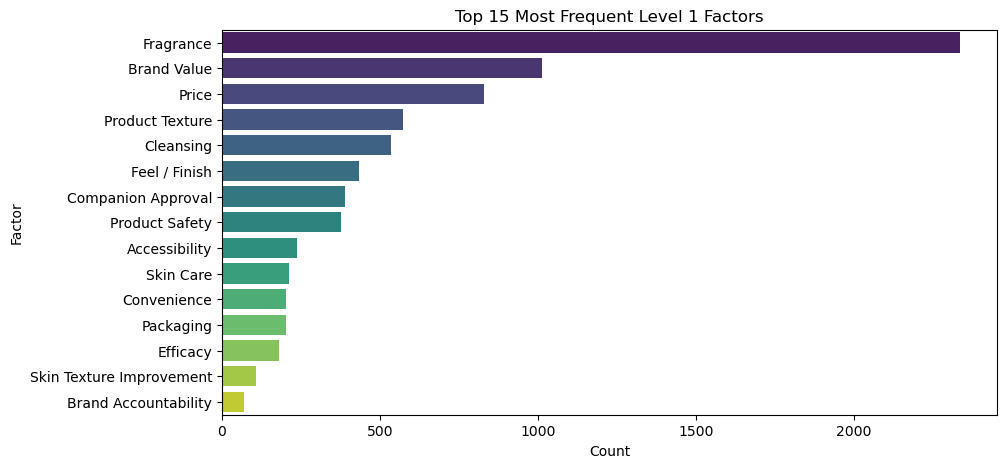

                      Factor  Count
0                  Fragrance   2335
1                Brand Value   1012
2                      Price    828
3            Product Texture    573
4                  Cleansing    534
5              Feel / Finish    435
6         Companion Approval    390
7             Product Safety    376
8              Accessibility    239
9                  Skin Care    211
10               Convenience    204
11                 Packaging    202
12                  Efficacy    181
13  Skin Texture Improvement    107
14      Brand Accountability     71
15              Brand For Me     46


In [24]:
factor_counts = train_df["Level 1 Factors"].value_counts().reset_index()
factor_counts.columns = ["Factor", "Count"]
plt.figure(figsize=(10,5))
sns.barplot(y="Factor", x="Count", data=factor_counts.head(15), palette="viridis")
plt.title("Top 15 Most Frequent Level 1 Factors")
plt.show()
print(factor_counts.head(20))


# 4️⃣ Example Texts for Top Factors

In [25]:

examples = []
for f in factor_counts["Factor"].head(5):
    sample = train_df[train_df["Level 1 Factors"] == f]["Core Item"].sample(3, random_state=42).tolist()
    examples.append({"Factor": f, "Examples": sample})
display(pd.DataFrame(examples))

# ================================================================
# 5️⃣ Prepare for Model Inference
# ================================================================
unique_factors = sorted(train_df["Level 1 Factors"].dropna().unique().tolist())
print(f"Total unique factors: {len(unique_factors)}")
print(unique_factors)



,Factor,Examples
0,Fragrance,[Smooth feeling-This is a great body wash ! Th...
1,Brand Value,[Incredible-I've used old spice body wash for ...
2,Price,[Nice scent-This is my first time trying this ...
3,Product Texture,[Surf and sea-My boyfriend loves this in the s...
4,Cleansing,[Great product-Love the way that my husband sm...


Total unique factors: 16
['Accessibility', 'Brand Accountability', 'Brand For Me', 'Brand Value', 'Cleansing', 'Companion Approval', 'Convenience', 'Efficacy', 'Feel / Finish', 'Fragrance', 'Packaging', 'Price', 'Product Safety', 'Product Texture', 'Skin Care', 'Skin Texture Improvement']


# 6️⃣ Configure Groq Cloud API

In [ ]:
GROQ_API_KEY = "GROQ_API_KEY"  # 🔑 Replace with your actual key
MODEL = "llama-3.1-8b-instant"
RATE_LIMIT_SLEEP = 2.3   # safe for free tier (≈26 req/min)
RETRY_SLEEP = 8
MAX_RETRIES = 5

def clean_prediction(text):
    """Strictly clean model outputs to keep only factor names."""
    if not isinstance(text, str): return ""
    text = re.sub(r'(?i)(based on|because|the relevant|factors? (are|include)|review).*?:', '', text)
    if ":" in text: text = text.split(":")[-1]
    text = re.sub(r'[^A-Za-z0-9, /&-]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip(" ,")
    tokens = [t.strip() for t in text.split(",") if len(t.strip()) > 1]
    return ", ".join(tokens)

def classify_with_groq(text, factors_list):
    """Classify one review using Groq Cloud LLaMA 3 model."""
    prompt = f"""
You are an NLP assistant classifying customer bodywash reviews.
Given this review:
"{text}"

Select all relevant Level 1 factors from this list:
{', '.join(factors_list)}

Return ONLY the applicable factor names separated by commas.
Example: Fragrance, Brand Value, Price
    """
    headers = {"Authorization": f"Bearer {GROQ_API_KEY}"}
    payload = {"model": MODEL,
               "messages": [{"role": "user", "content": prompt}],
               "temperature": 0.1}
    retries = 0
    while retries < MAX_RETRIES:
        try:
            r = requests.post("https://api.groq.com/openai/v1/chat/completions",
                              headers=headers, data=json.dumps(payload), timeout=60)
            if r.status_code == 200:
                content = r.json()["choices"][0]["message"]["content"].strip()
                return clean_prediction(content)
            elif "rate_limit_exceeded" in r.text:
                print("⚠️ Rate limit reached, waiting 8s...")
                time.sleep(RETRY_SLEEP)
                retries += 1
            else:
                print("⚠️ Error:", r.text)
                retries += 1
                time.sleep(5)
        except Exception as e:
            print("⚠️ Network error:", e)
            retries += 1
            time.sleep(5)
    return ""



# 7️⃣ Prediction Loop with Rate Limit Handling

In [30]:
predictions = []
for i, text in enumerate(tqdm(test_df["Core Item"], desc="Predicting Factors")):
    label = classify_with_groq(text, unique_factors)
    predictions.append(label)
    time.sleep(RATE_LIMIT_SLEEP)
test_df["Predicted_Factors"] = predictions
print("✅ Prediction completed.")

Predicting Factors:  75%|███████▍  | 95/127 [07:19<03:35,  6.73s/it]

⚠️ Network error: HTTPSConnectionPool(host='api.groq.com', port=443): Read timed out. (read timeout=60)
⚠️ Network error: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
⚠️ Network error: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


Predicting Factors:  92%|█████████▏| 117/127 [11:05<00:42,  4.30s/it]

⚠️ Network error: HTTPSConnectionPool(host='api.groq.com', port=443): Max retries exceeded with url: /openai/v1/chat/completions (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000285F32002D0>, 'Connection to api.groq.com timed out. (connect timeout=60)'))


Predicting Factors:  95%|█████████▌| 121/127 [12:10<00:55,  9.22s/it]

⚠️ Network error: HTTPSConnectionPool(host='api.groq.com', port=443): Max retries exceeded with url: /openai/v1/chat/completions (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000285F30E7C50>, 'Connection to api.groq.com timed out. (connect timeout=60)'))


Predicting Factors: 100%|██████████| 127/127 [13:14<00:00,  6.26s/it]


✅ Prediction completed.


# 8️⃣ Save Final Output (2 Columns Only)

In [32]:
final_df = test_df[["Core Item", "Predicted_Factors"]]
final_df.to_csv("../result/bodywash-test-final.csv", index=False)
print("✅ Final file saved as 'bodywash-test-final.csv'")
display(final_df.head(10))

✅ Final file saved as 'bodywash-test-final.csv'


,Core Item,Predicted_Factors
0,"""All of the body washes are excellent and they...","Fragrance, Brand Value, Product Safety, Skin Care"
1,"""Cremo is by far the best!""","Brand Value, Efficacy, Fragrance"
2,"""I use the Nivea's during the spring and summe...","Brand Accountability, Brand Value, Product Tex..."
3,"""Nivea and Dove. Both are great on my skin. No...","Cleansing, Feel / Finish, Efficacy, Product Te..."
4,"""OG, The one thing that would hold me back fro...","Product Safety, Brand Value, Price"
5,"""Should try Old Spice moisturizing body wash w...","Fragrance, Efficacy, Feel / Finish, Brand Value"
6,"""That's bullshit, old spice just like every ot...","Fragrance, Brand Value, Price"
7,"16oz Shiso-What a great product, this body was...","Fragrance, Feel / Finish, Efficacy, Skin Care,..."
8,A very nice bodywash that doesn't overwhelm-I ...,"Fragrance, Cleansing, Efficacy, Convenience, B..."
9,Absolutely love it. Great scents and good pric...,"Fragrance, Brand Value, Price, Cleansing, Skin..."


# 9️⃣ Summary

In [31]:
print("""
✅ Completed full EDA and Groq Cloud zero-shot classification.
✅ Strictly cleaned model outputs (no reasoning text).
✅ Automatic retry and rate-limit protection.
✅ Final deliverable: 'bodywash-test-final.csv'
Columns: Core Item | Predicted_Factors
""")



✅ Completed full EDA and Groq Cloud zero-shot classification.
✅ Strictly cleaned model outputs (no reasoning text).
✅ Automatic retry and rate-limit protection.
✅ Final deliverable: 'bodywash-test-final.csv'
Columns: Core Item | Predicted_Factors

